In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [ ]:
df = pd.read_csv("DelayedFlights.csv")
df = df.drop("Unnamed: 0", 1)

In [ ]:
print(df.head())
# print(df.describe())
# print(df.info())

### Data Cleaning

In [ ]:
# Total

# missing_values_count = df.isnull().sum()
# print(missing_values_count)

# total_cells = np.product(df.shape)
# total_missing = missing_values_count.sum()

# percent_missing = (total_missing/total_cells) * 100
# print(percent_missing)

# Ver los que tiene menos valores nulos
missing_values_count = df['AirTime'].isnull().sum()
print(missing_values_count)

total_cells = np.product(df['AirTime'].shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

# Ver los que tienen mayor valores nulos
missing_values_count = df[('CarrierDelay')].isnull().sum()
print(missing_values_count)

total_cells = np.product(df['CarrierDelay'].shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

In [86]:
# Imputar los valores faltantes con la media
df['ArrTime'].fillna(df['ArrTime'].mean(), inplace=True)
df['ActualElapsedTime'].fillna(df['ActualElapsedTime'].mean(), inplace=True)
df['CRSElapsedTime'].fillna(df['CRSElapsedTime'].mean(), inplace=True)
df['AirTime'].fillna(df['AirTime'].mean(), inplace=True)
df['ArrDelay'].fillna(df['ArrDelay'].mean(), inplace=True)
df['TaxiIn'].fillna(df['TaxiIn'].mean(), inplace=True)
df['TaxiOut'].fillna(df['TaxiOut'].mean(), inplace=True)

# Interpolacion
df['CarrierDelay']=df['CarrierDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['WeatherDelay']=df['WeatherDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['NASDelay']=df['NASDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['SecurityDelay']=df['SecurityDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation

In [ ]:
# Verificar si hay valores negativos
print(all(i < 0 for i in df['ArrTime']))
print(all(i < 0 for i in df['CRSArrTime']))
print(all(i < 0 for i in df['DepTime']))
print(all(i < 0 for i in df['CRSDepTime']))


# EDA

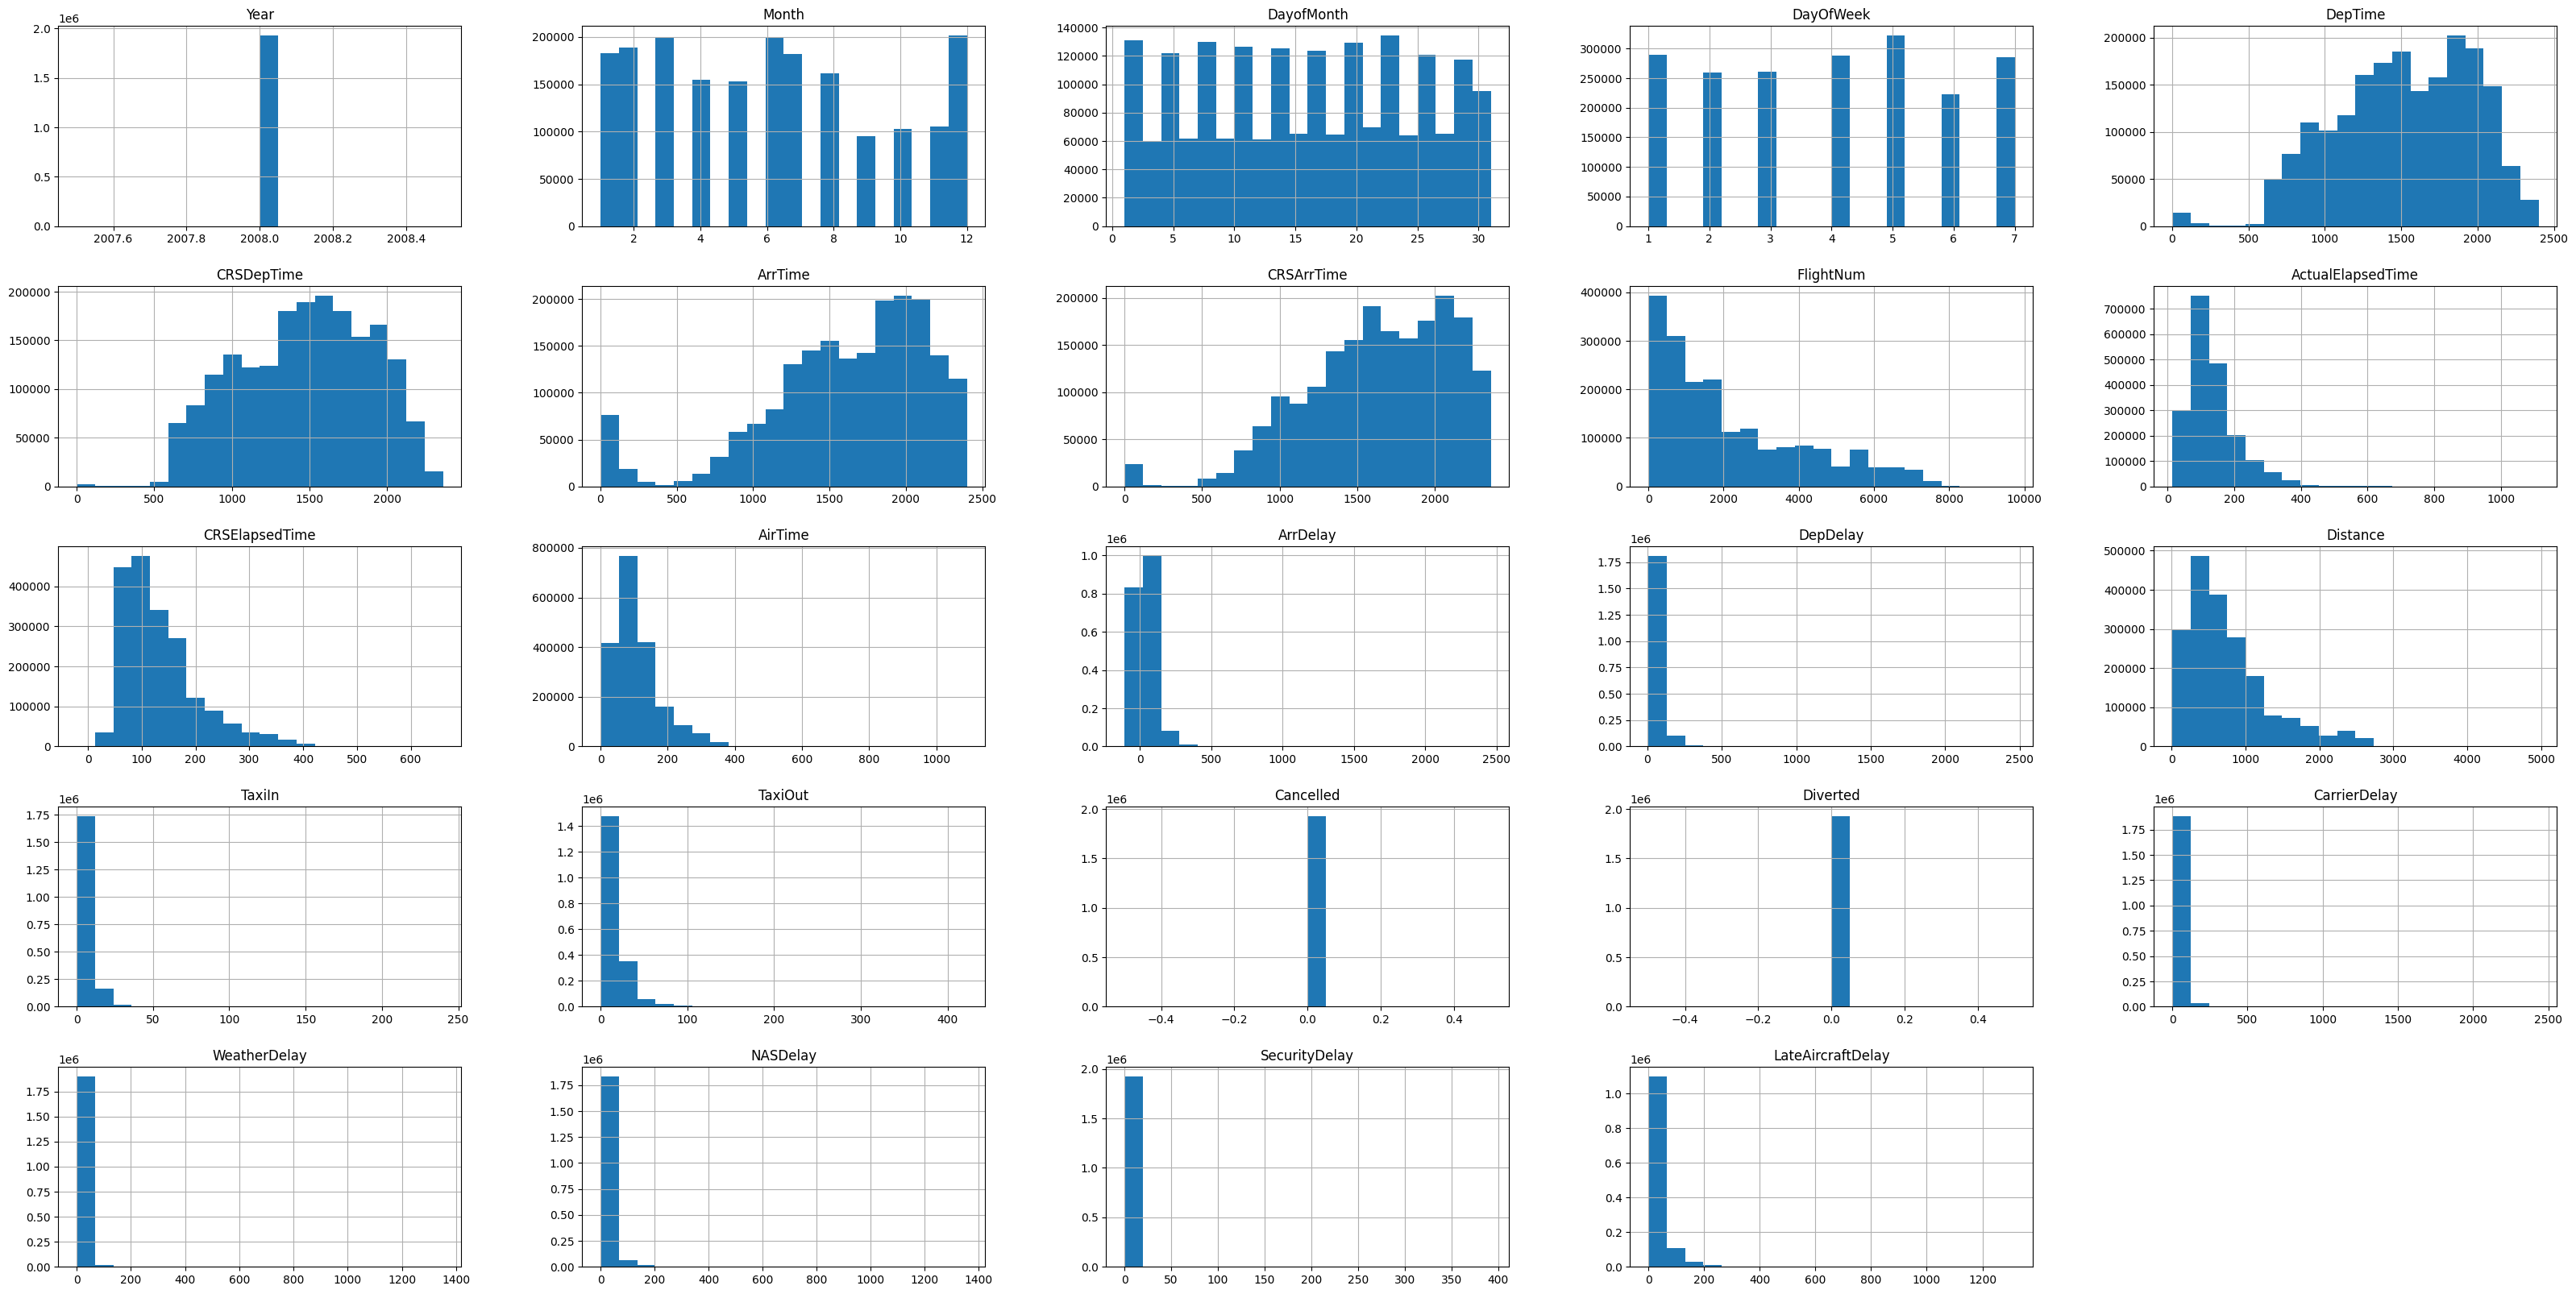

In [74]:

# Crear histogramas de las columnas numéricas
df.hist(bins=20, figsize=(40,20))
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_13068\2992616574.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


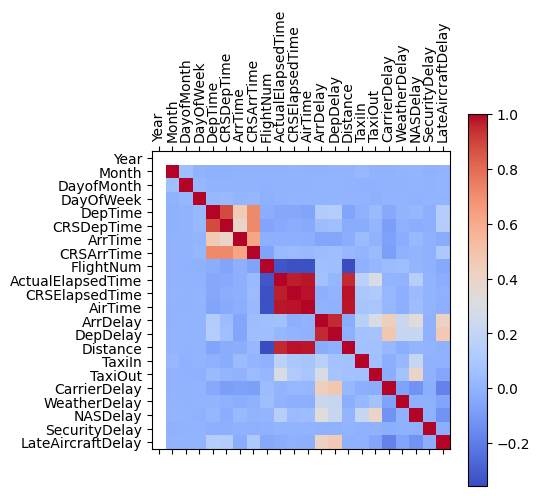

In [97]:
# Calcular la correlación entre las columnas numéricas
corr_matrix = df.corr()
# Visualizar la matriz de correlación como un mapa de calor
plt.matshow(corr_matrix, cmap='coolwarm')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.show()

A través de la matriz de correlación podemos ver cómo algunas de las 29 variables del conjunto de datos presentan multicolinealidad, es decir, se pueden predecir linealmente a partir de las demás. Para tener un mejor análisis y trabajar con un conjunto de datos más ligero, vamos a eliminar algunas de esas variables no deseadas y crear otras nuevas.

<AxesSubplot: xlabel='Dest', ylabel='count'>

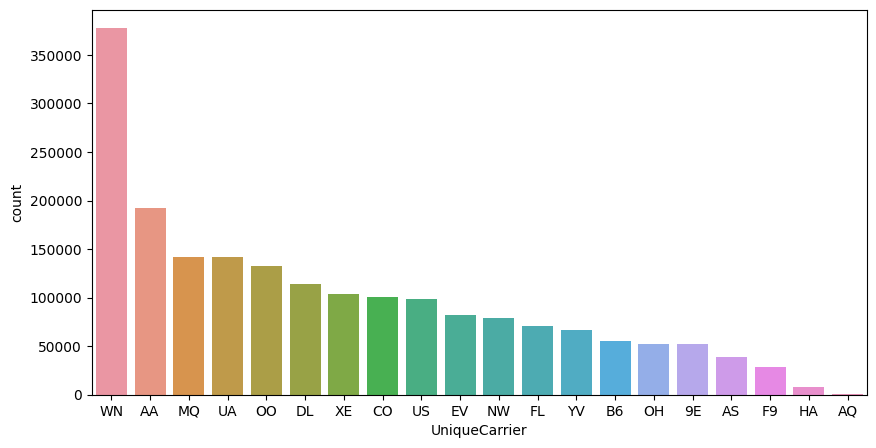

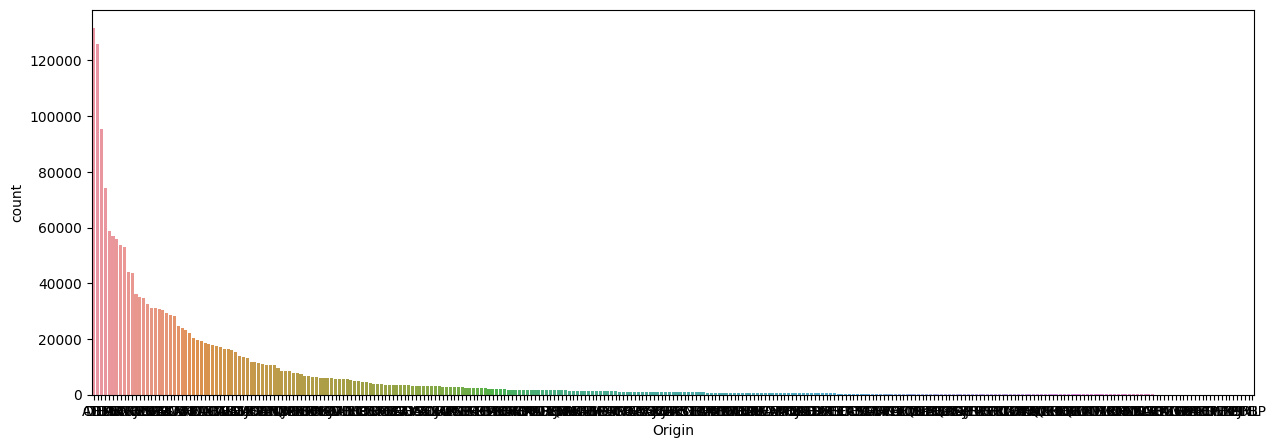

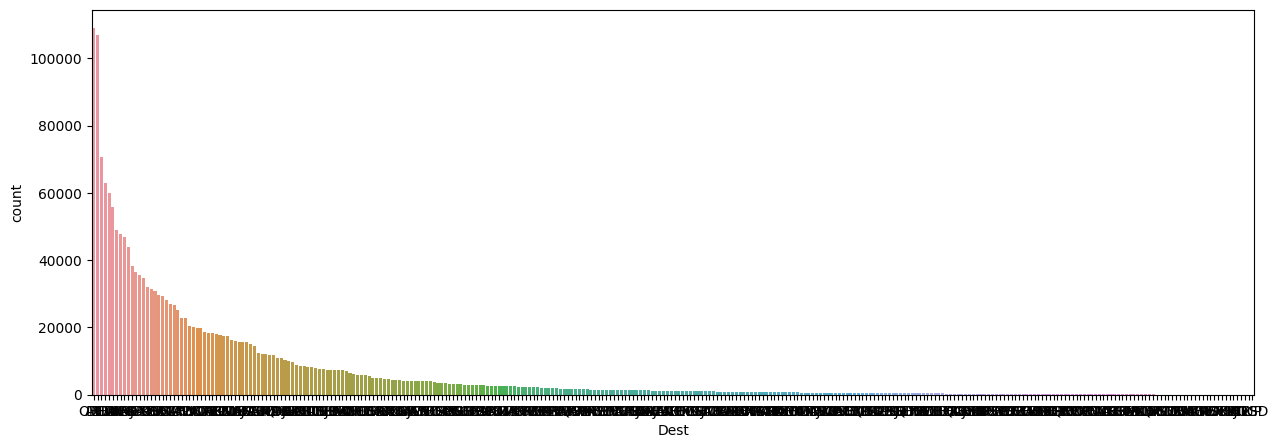

In [98]:
# análisis de la variable 'UniqueCarrier'
plt.figure(figsize=(10,5))
sns.countplot(x='UniqueCarrier', data=df, order=df['UniqueCarrier'].value_counts().index)

# análisis de la variable 'Origin'
plt.figure(figsize=(15,5))
sns.countplot(x='Origin', data=df, order=df['Origin'].value_counts().index)

# análisis de la variable 'Dest'
plt.figure(figsize=(15,5))
sns.countplot(x='Dest', data=df, order=df['Dest'].value_counts().index)


<AxesSubplot: >

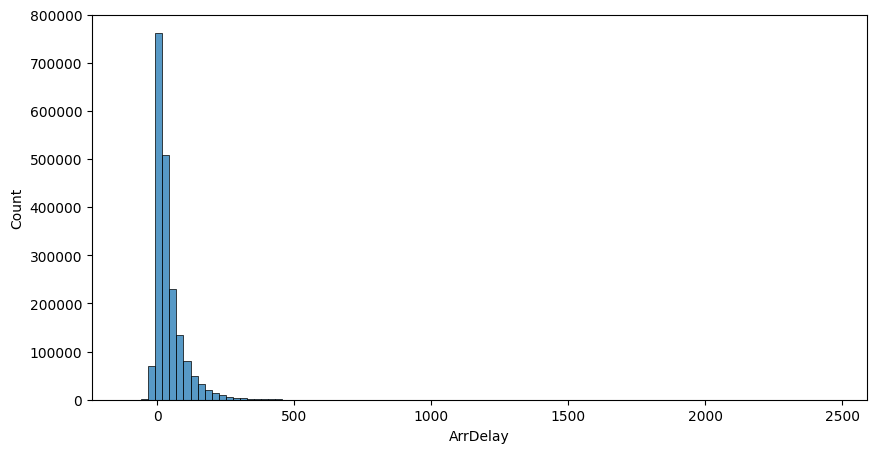

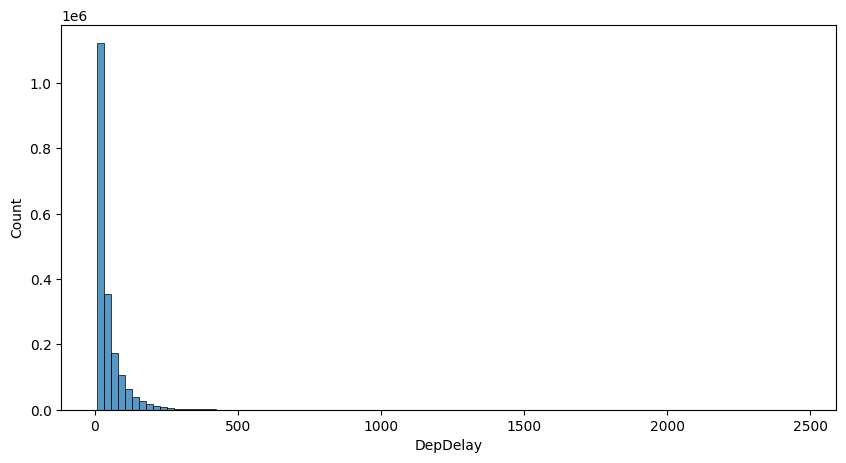

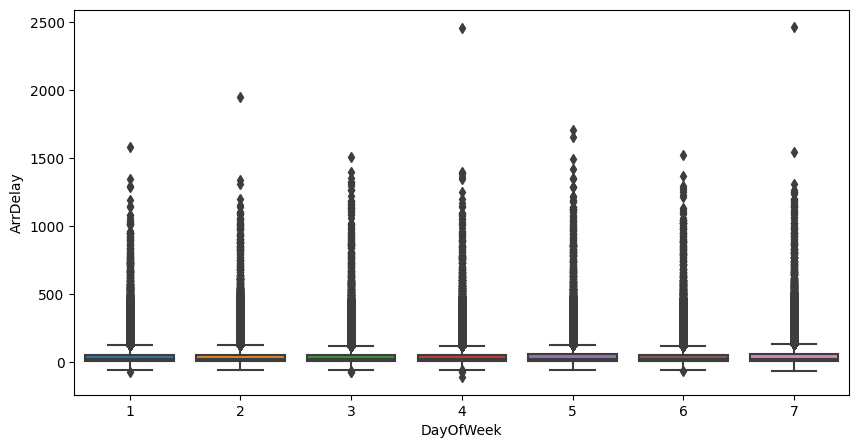

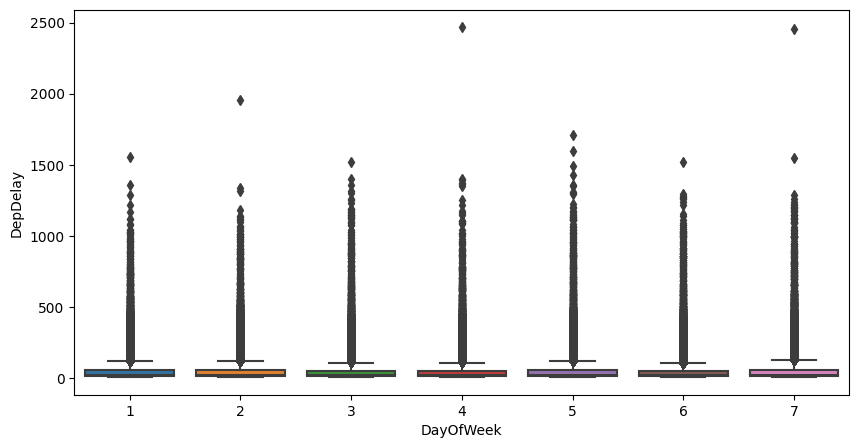

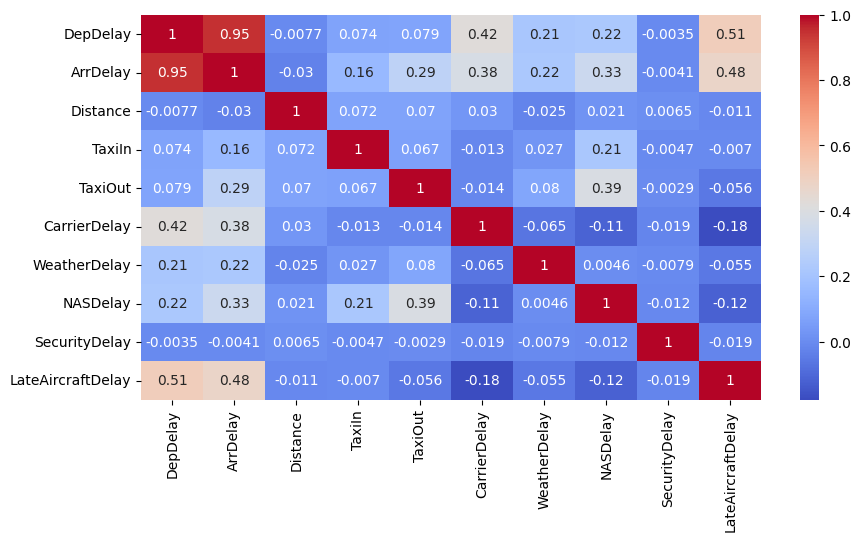

In [87]:
# histograma de la variable 'ArrDelay'
plt.figure(figsize=(10,5))
sns.histplot(df['ArrDelay'].dropna(), kde=False, bins=100)

# histograma de la variable 'DepDelay'
plt.figure(figsize=(10,5))
sns.histplot(df['DepDelay'].dropna(), kde=False, bins=100)

# boxplot de la variable 'ArrDelay' por día de la semana
plt.figure(figsize=(10,5))
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df)

# boxplot de la variable 'DepDelay' por día de la semana
plt.figure(figsize=(10,5))
sns.boxplot(x='DayOfWeek', y='DepDelay', data=df)

# matriz de correlación de las variables numéricas
corr = df[['DepDelay', 'ArrDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')


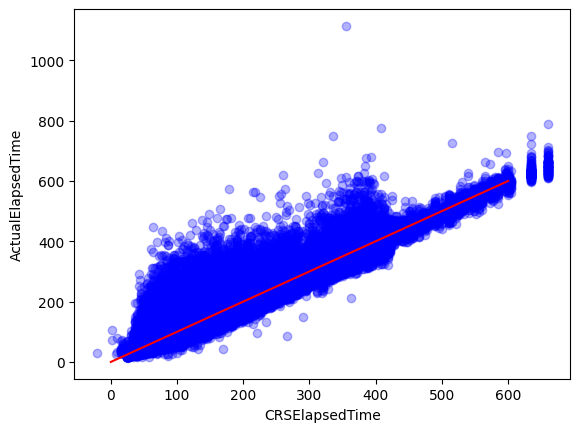

In [76]:
plt.scatter(df['CRSElapsedTime'], df['ActualElapsedTime'], alpha=0.3, color='blue')
plt.plot([0, 600], [0, 600], color='red')
plt.xlabel('CRSElapsedTime')
plt.ylabel('ActualElapsedTime')
plt.show()

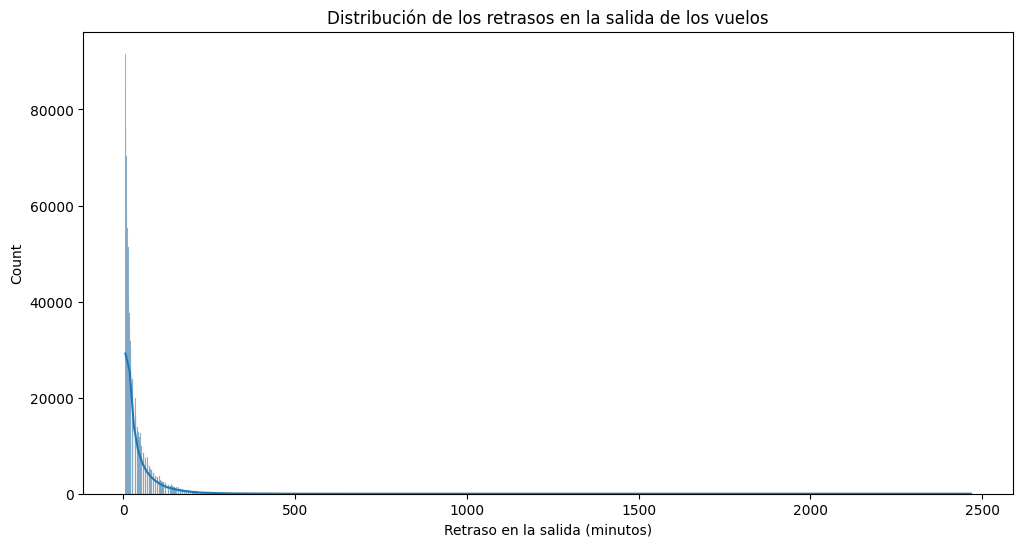

In [88]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="DepDelay", kde=True)
plt.title("Distribución de los retrasos en la salida de los vuelos")
plt.xlabel("Retraso en la salida (minutos)")
plt.show()

El gráfico muestra que la mayoría de los retrasos son de menos de 100 minutos y que la frecuencia disminuye a medida que aumenta el retraso.

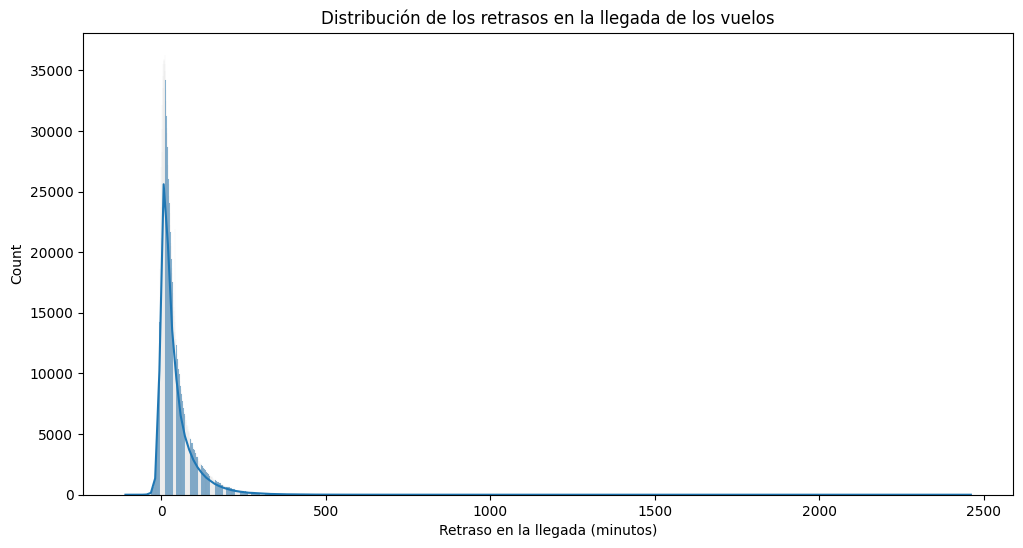

In [89]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="ArrDelay", kde=True)
plt.title("Distribución de los retrasos en la llegada de los vuelos")
plt.xlabel("Retraso en la llegada (minutos)")
plt.show()

El gráfico muestra una distribución similar a la anterior, con la mayoría de los retrasos siendo de menos de 100 minutos.

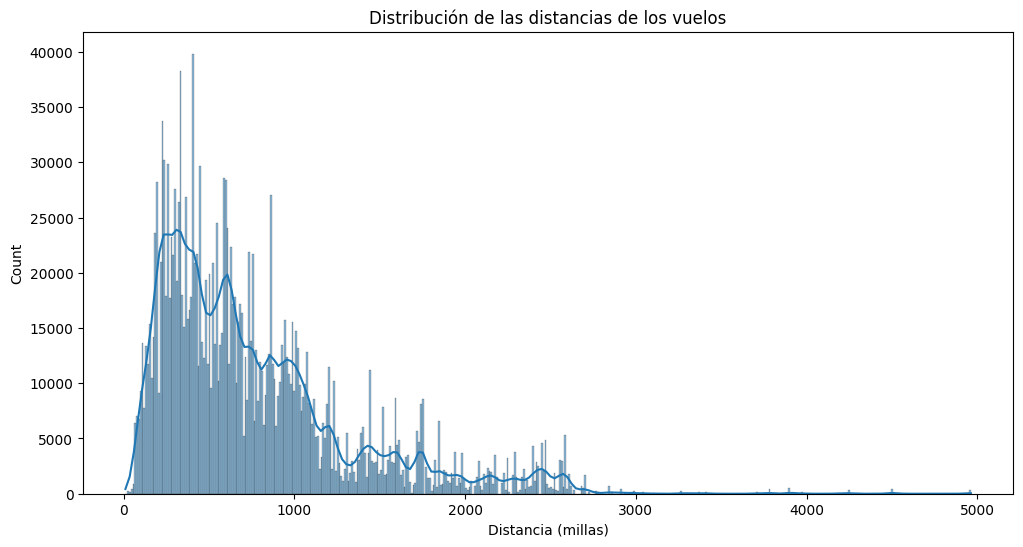

In [90]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="Distance", kde=True)
plt.title("Distribución de las distancias de los vuelos")
plt.xlabel("Distancia (millas)")
plt.show()

In [91]:
for dataset in df:
    df.loc[df['ArrDelay'] <= 15, 'Status'] = 0
    df.loc[df['ArrDelay'] >= 15, 'Status'] = 1
    df.loc[df['ArrDelay'] >= 60, 'Status'] = 2
    df.loc[df['Diverted'] == 1, 'Status'] = 3
    df.loc[df['Cancelled'] == 1, 'Status'] = 4

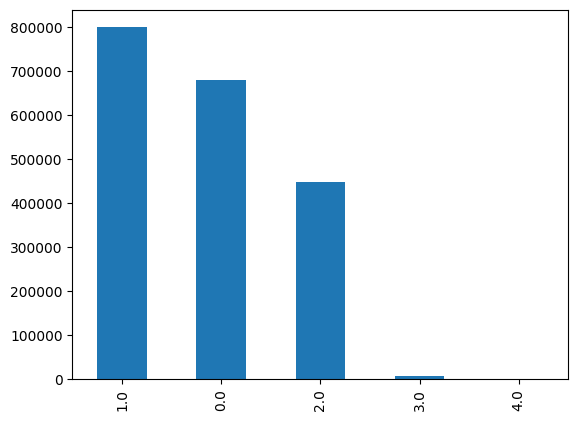

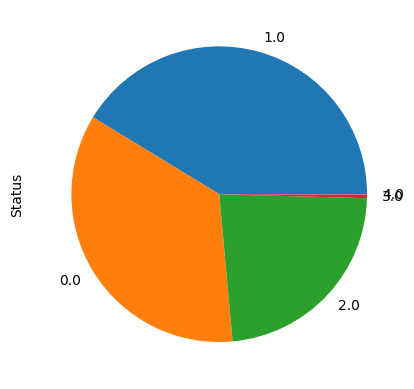

Status representa si el vuelo llegó a tiempo (0), ligeramente retrasado (1), muy retrasado (2), desviado (3) o cancelado (4)


In [92]:
df['Status'].value_counts().plot.bar()
plt.show()
df['Status'].value_counts().plot.pie()
plt.show()
print('Status representa si el vuelo llegó a tiempo (0), ligeramente retrasado (1), muy retrasado (2), desviado (3) o cancelado (4)')

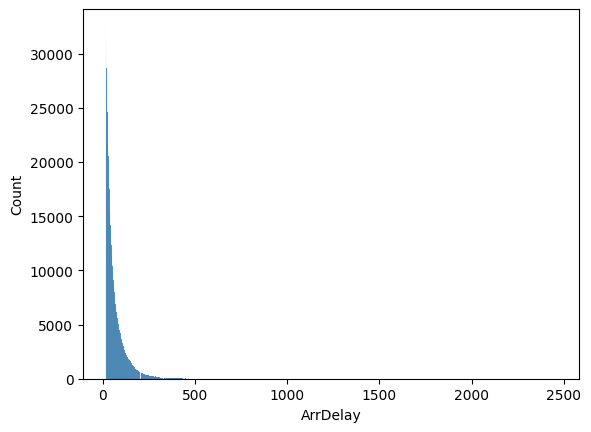

In [93]:
Delayedflights = df[(df.Status >= 1) &(df.Status < 3)]
#histogram
sns.histplot(Delayedflights['ArrDelay'])
plt.show()

La mayoría de los retrasos son cortos, y los retrasos más largos, aunque inusuales, tienen una mayor carga de tiempo.

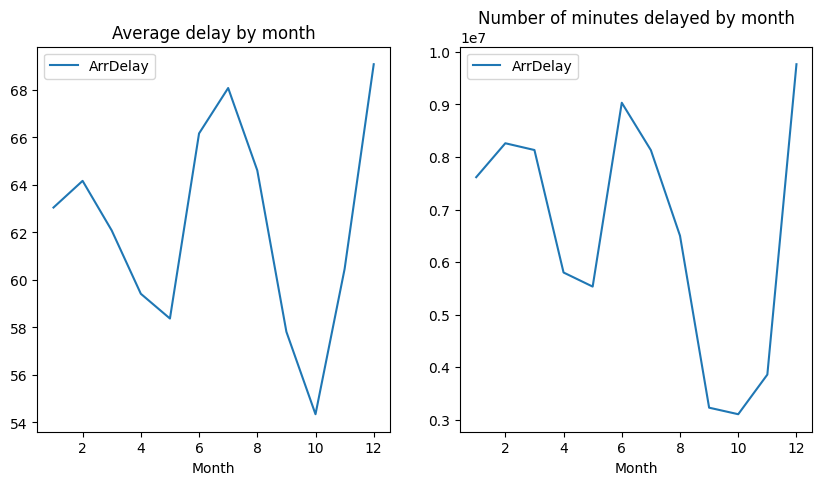

In [94]:
f,ax=plt.subplots(1,2,figsize=(10,5))
Delayedflights[['Month','ArrDelay']].groupby(['Month']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['Month','ArrDelay']].groupby(['Month']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

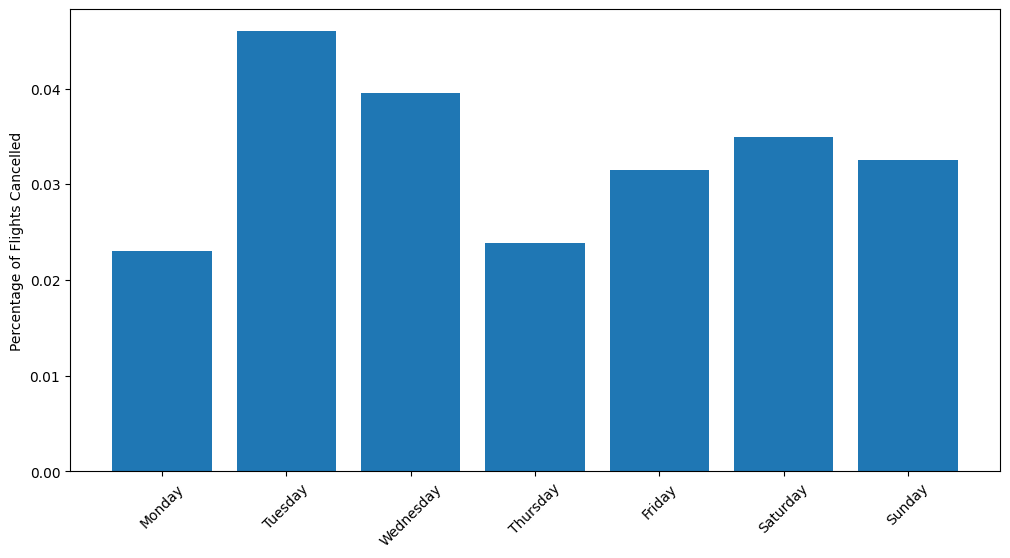

In [95]:

cancelled = df[df['Cancelled']==1]

days_cancelled = cancelled['Cancelled'].groupby(df['DayOfWeek']).count()
days_total = df['Cancelled'].groupby(df['DayOfWeek']).count()
days_frac = np.divide(days_cancelled, days_total)
x=days_frac.index.values
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize = (12,6))
ax.bar(x,days_frac*100, align='center')
ax.set_ylabel('Percentage of Flights Cancelled')
ax.set_xticks(x)
ax.set_xticklabels(week, rotation = 45)

plt.show()

# Parte sistemas

Seleccionar variables 

In [100]:
new_df = df.loc[:, ['Origin', 'Dest', 'Distance']]
new_df.head()

,Origin,Dest,Distance
0,IAD,TPA,810
1,IAD,TPA,810
2,IND,BWI,515
3,IND,BWI,515
4,IND,JAX,688
